**Project Name: *Gaining Insights into the Research Reproducibility Problem through Survey Data Analysis*** <br>
Team Name: ISR_4349 <br>
Team Members: Miftahul Jannat Mokarrama (Z1936043), C Bradford (Z1828449) <br>
Semester: Fall 2021 <br>
Course code: CSCI 642 






# Task 1: Topics modeling using GSDMM with texual response

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

data = pd.read_csv('reproducibility_survey_raw_data.csv') 

In [2]:
#pip install wordcloud

###  Step 1: Data exploration and preprocessing for Topic Modeling

In [3]:
data.columns

Index(['responseid', 'respid', 'interview_start', 'interview_end', 'status',
       'In your current role do you carry out primary research?',
       'Have you published a manuscript in the past 3 years?', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9',
       ...
       'Other specialty within medicine?',
       'What is your specialty within physics?',
       'Other specialty within physics?', 'In which continent do you live?',
       'Which country in Asia (including Middle East)?',
       'Which country in Australasia?', 'Which country in Africa?',
       'Which country in Europe?',
       'Which country in North America (including Central America and the Caribbean)?',
       'Which country in South America?'],
      dtype='object', length=115)

In [4]:
#question for which we are going to get the topics from text-responses
question='Use the box below to tell us about the steps that have been taken to ensure reproducibility in your work?'
data=data[data[question].notnull()].reset_index(drop=True)

In [5]:
text=data[question].to_frame()

In [6]:
text.describe()

,Use the box below to tell us about the steps that have been taken to ensure reproducibility in your work?
count,636
unique,625
top,Err:509
freq,12


In [7]:
text = text.rename({question: 'text_response'}, axis=1) 

In [8]:
#remove the top errornous text input
text.drop(text[text['text_response']== 'Err:509'].index, inplace = True)

In [9]:
text.text_response

0      Using established scales, standardized measure...
1      we record from neurones and they need to match...
3      I work in computational science, so it is stan...
4      Ensuring all analysis parameters are standardised
5      We keeping track of all parameters in programs...
                             ...                        
631              Share data online, share methods online
632    it is early stage, but we tend to record more ...
633    protocols, explicit methodology, open communic...
634    We are at a time of major transition, but we h...
635    Even though many of our studies are blinded, w...
Name: text_response, Length: 624, dtype: object

In [10]:
import re

text_list=text.text_response.tolist()            # convert to list of text
text_data=pd.DataFrame({'text_list': text_list}) # create new dataframe 'text_data' with only column 'text_list' 

for i in range(text_data['text_list'].count()):
    text_data.at[i,'text_list'] = re.sub(r'[^a-zA-Z ]',r'',text_data['text_list'][i]) # Keep only alphabetic texts by using regular expression 

In [11]:
# create new column with corresponding length value
text_data['text_length']=text_data.text_list.str.len() 
text_data.head(5)

,text_list,text_length
0,Using established scales standardized measures...,86
1,we record from neurones and they need to match...,187
2,I work in computational science so it is stand...,385
3,Ensuring all analysis parameters are standardised,49
4,We keeping track of all parameters in programs...,165


In [12]:
# Ignore the warnings related to packages that may arise for version difference of python 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

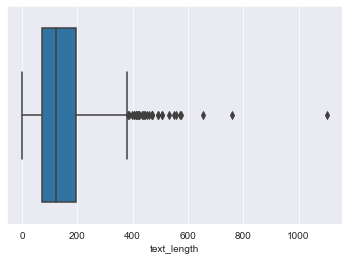

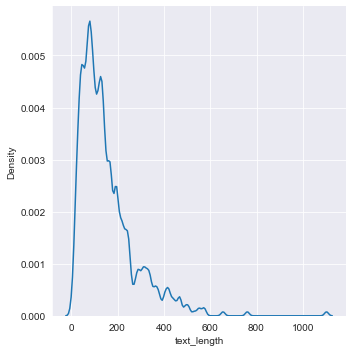

In [13]:
#Look into the text length distribution for preprocessing
import seaborn as sns
sns.set_style(style="darkgrid")
sns.boxplot(text_data['text_length'])

sns.displot(text_data['text_length'], kind="kde", bw_adjust=.25)


In [14]:
# remove texts with 200<length<5
data1=text_data[(text_data['text_length']>200) | (text_data['text_length']<5)]  
text_data=text_data.drop(data1.index)   
text_data.sort_values(by=['text_length'], ascending=False).tail()

,text_list,text_length
423,Software libre,14
488,Nosense zone,12
142,GLP ISOIEC,11
317,triplicate,10
233,Try again,9


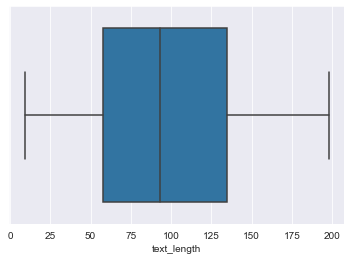

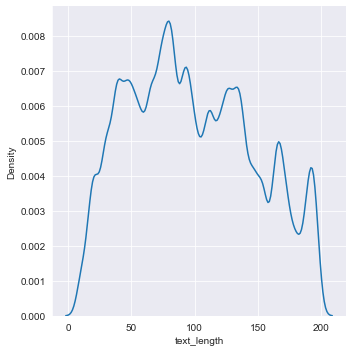

In [15]:
# look into the text plots after preprocessing
sns.boxplot(text_data['text_length'])

sns.displot(text_data['text_length'], kind="kde", bw_adjust=.25)

In [16]:
text_data['text_length'].describe()

count    468.000000
mean      98.089744
std       48.907863
min        9.000000
25%       58.000000
50%       93.000000
75%      135.000000
max      198.000000
Name: text_length, dtype: float64

In [17]:
# import necessary modules for Pre-processing using gensim 
import gensim, spacy

from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess

from gensim.models.ldamulticore import LdaMulticore


from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [18]:
#tokenization of each response
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [19]:
# creation of bgram-trigram model
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [20]:
# get tokenized response
token_response = list(sent_to_words(text_data['text_list']))


In [21]:
#get word sequences of three (trigram)
token_response = make_n_grams(token_response)


In [22]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# method for removing stop words. we used gensim stop-words and added some own stop-words, based on texts 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'page',
                                                                                                                             'use', 'include', 'there',  'soooo',]))] for doc in texts]
# method for lemmatization (converting to basic word format from different forms)
def lemmatization(texts, allowed_postags=['NOUN', 'VERB', 'ADV', 'ADJ']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# do lemmatization keeping only noun, verb, and adverb
response_lemmatized = lemmatization(token_response, allowed_postags=['NOUN', 'VERB', 'ADV', 'ADJ'])

# remove stop words after lemmatization
response_lemmatized = remove_stopwords(response_lemmatized)


### Step 2: Topic Modeling using GSDMM  <br> 
*We used GSDMM topic modeling as it works better in short texts compared to other models like LDA*

In [24]:
#set random seed for reproducibility
np.random.seed(0)

In [25]:
#Model building for topic modeling with MovieGroupProcess()
# alpha: controls completeness of clusters, beta: controls homogeniety of clusters
mgp = MovieGroupProcess(K=3, alpha=0.01, beta=0.005, n_iters=20) 

vocab = set(x for response in response_lemmatized for x in response)
n_terms = len(vocab)
model = mgp.fit(response_lemmatized, n_terms)

In stage 0: transferred 228 clusters with 3 clusters populated
In stage 1: transferred 132 clusters with 3 clusters populated
In stage 2: transferred 92 clusters with 3 clusters populated
In stage 3: transferred 72 clusters with 3 clusters populated
In stage 4: transferred 68 clusters with 3 clusters populated
In stage 5: transferred 55 clusters with 3 clusters populated
In stage 6: transferred 66 clusters with 3 clusters populated
In stage 7: transferred 71 clusters with 3 clusters populated
In stage 8: transferred 68 clusters with 3 clusters populated
In stage 9: transferred 66 clusters with 3 clusters populated
In stage 10: transferred 65 clusters with 3 clusters populated
In stage 11: transferred 73 clusters with 3 clusters populated
In stage 12: transferred 50 clusters with 3 clusters populated
In stage 13: transferred 50 clusters with 3 clusters populated
In stage 14: transferred 56 clusters with 3 clusters populated
In stage 15: transferred 51 clusters with 3 clusters populated


In [26]:
#find top words in each topics
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [27]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of documents they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 10 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [175 158 135]

Most important clusters (by number of docs inside): [0 1 2]

Cluster 0 : [('experiment', 84), ('repeat', 51), ('lab', 37), ('different', 37), ('result', 37), ('time', 36), ('replicate', 23), ('protocol', 22), ('method', 20), ('sample', 18)]

Cluster 1 : [('experiment', 46), ('datum', 27), ('result', 27), ('procedure', 27), ('protocol', 24), ('repeat', 23), ('method', 22), ('analysis', 20), ('check', 18), ('lab', 17)]

Cluster 2 : [('datum', 26), ('result', 23), ('code', 22), ('work', 21), ('publish', 18), ('experiment', 16), ('different', 15), ('procedure', 15), ('protocol', 14), ('method', 14)]


In [28]:
#renaming sorted clusters as topic number
topic_dict = {}
topic_names = ['topic 1',
               'topic 2',
               'topic 3',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [29]:
#method for document-wise topics 
def create_topics_dataframe(data_text=text_data['text_list'],  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=response_lemmatized):
    result = pd.DataFrame(columns=['response', 'topic', 'response_length', 'lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'response'] = text
        result.at[i, 'response_length'] = len(text)
        result.at[i, 'lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(response_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'topic'] = 'Other'
    return result

In [30]:
# create and display document-wise topics 
result = create_topics_dataframe(data_text=text_data['text_list'], mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=response_lemmatized)
result.tail(5)

,response,topic,response_length,lemma-text
463,Regular staff meetingssometimes quite heated,topic 1,44,"[regular, staff, heated]"
464,Share data online share methods online,topic 3,38,"[share, datum, online, share, method, online]"
465,it is early stage but we tend to record more m...,topic 3,114,"[early, stage, tend, record, metadata, version..."
466,protocols explicit methodology open communicat...,topic 3,84,"[protocol, explicit, methodology, open, commun..."
467,We are at a time of major transition but we ha...,topic 1,192,"[time, major, transition, struggle, establish,..."


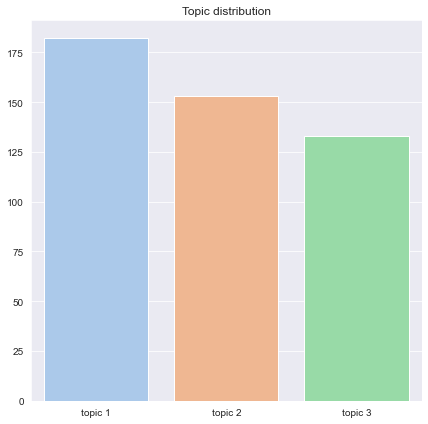

In [31]:
import matplotlib.pyplot as plt

# visualize topic distribution
types_counts = result.topic.value_counts()
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Topic distribution')
types = sns.barplot(x = types_counts.index, y = types_counts.values, palette="pastel") # topic-wise post count 
%timeit

### Step 3: Word clouds of each topic

In [32]:
result['lemma_text'] = result['lemma-text'].apply(lambda row: ' '.join(row))

In [33]:
result = result.drop('lemma-text', axis=1)

In [34]:
from wordcloud import WordCloud 

In [35]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (7, 7), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

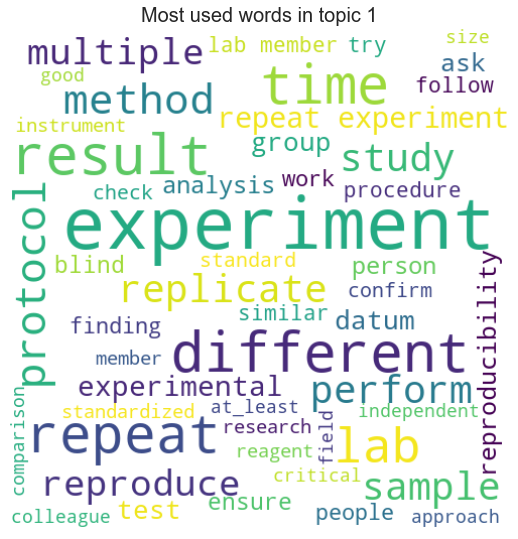

In [36]:
create_WordCloud(result['lemma_text'].loc[result.topic == 'topic 1'], title="Most used words in topic 1")

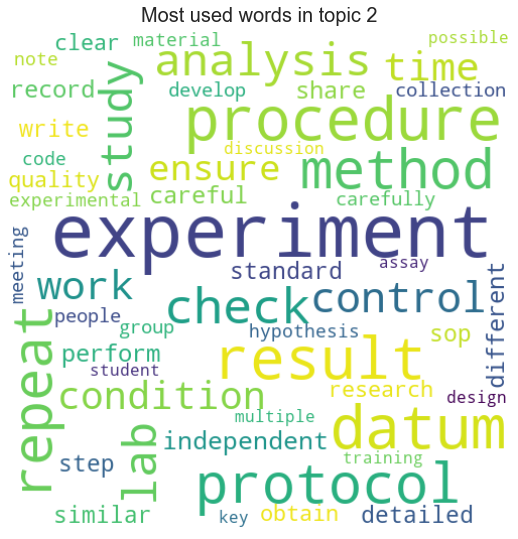

In [37]:
create_WordCloud(result['lemma_text'].loc[result.topic == 'topic 2'], title="Most used words in topic 2")

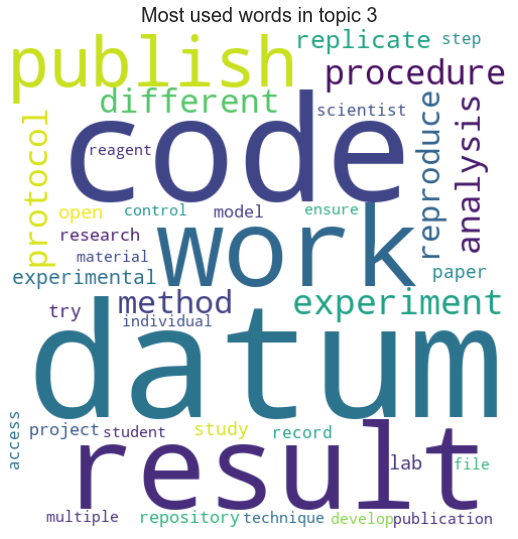

In [38]:
create_WordCloud(result['lemma_text'].loc[result.topic == 'topic 3'], title="Most used words in topic 3")

# Task 2: Data Visualization with type-1 and type-2 data in survey
*  type-1: Multiple choice questions (MCQ) having binary response (yes/no or 0/1)) 
*  type-2: (MCQ having categorical response)

In [39]:
#!pip install more_itertools 

In [40]:
import more_itertools as mit

In [41]:
#load dataset
data = pd.read_csv('reproducibility_survey_raw_data.csv') 

## *Step1: Data exploration and some Preprocessing*

In [42]:
data.columns

Index(['responseid', 'respid', 'interview_start', 'interview_end', 'status',
       'In your current role do you carry out primary research?',
       'Have you published a manuscript in the past 3 years?', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9',
       ...
       'Other specialty within medicine?',
       'What is your specialty within physics?',
       'Other specialty within physics?', 'In which continent do you live?',
       'Which country in Asia (including Middle East)?',
       'Which country in Australasia?', 'Which country in Africa?',
       'Which country in Europe?',
       'Which country in North America (including Central America and the Caribbean)?',
       'Which country in South America?'],
      dtype='object', length=115)

In [43]:
data.drop(['responseid','respid','interview_start','interview_end','status'], axis=1, inplace=True)


In [44]:
#Since it's difficult to predict user responses, we will remove columns having null responses 
data.dropna(axis='columns', inplace=True)
data.head()

,Have you published a manuscript in the past 3 years?,Unnamed: 7,Unnamed: 8,Unnamed: 9,"Is a 'crisis of reproducibility' something you have heard of before, as an issue in science?",Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 18,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,"Which, if any, of the following have you done?",Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83
0,"Yes, in an NPG journal","Yes, in a non-NPG journal",No,I would prefer not to say,"Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences","Yes, from discussions with my colleagues","Yes, from elsewhere",No,...,More emphasis on independent replication via o...,Journal editors enforcing standards to enhance...,More time to teach and mentor students and oth...,More time checking lab notebooks and raw data,Tried and failed to reproduce one of your own ...,Tried and failed to reproduce someone else's e...,Published a successful attempt to reproduce so...,Published a failed attempt to reproduce someon...,Tried and failed to publish a successful repro...,Tried and failed to publish an unsuccessful re...
1,0,1,0,0,0,1,0,0,0,0,...,Likely,Very likely,Likely,Likely,Yes,Yes,Yes,No,Yes,Yes
2,0,0,1,0,0,1,0,1,0,0,...,Likely,Not very likely,Likely,Very likely,No,No,No,No,No,No
3,0,1,0,0,1,1,1,1,0,0,...,Likely,Likely,Very likely,Very likely,No,Yes,No,Yes,Yes,No
4,1,0,0,0,0,1,0,0,0,0,...,Likely,Likely,Likely,Likely,Yes,Yes,Yes,Yes,No,No


In [45]:
#column locations of All MCQ Questions in the filtered survey response that we will visualize

data.iloc[:,[0,4,10,12,15,17,31,42]] 

,Have you published a manuscript in the past 3 years?,"Is a 'crisis of reproducibility' something you have heard of before, as an issue in science?",To what extent do you agree or disagree with the following statements?,How often do you do any of the following?,To what extent do you agree or disagree with the following statements:,Please use the scale below to indicate how much each of the following factors contributes to a failure to reproduce results:,Please use the scale below to indicate how likely you think the following factors would be to improve the reproducibility of research.,"Which, if any, of the following have you done?"
0,"Yes, in an NPG journal","Yes, from the mainstream media","""I think that the failure to reproduce scienti...",Think about reproducibility of your research,"""I think that a failure to reproduce a result ...",Fraud (i.e. fabricated or falsified results),Professional incentives (e.g. funding or publi...,Tried and failed to reproduce one of your own ...
1,0,0,Agree,Monthly,Strongly agree,Always contributes,Very likely,Yes
2,0,0,Agree,Monthly,Disagree,Very often contributes,Likely,No
3,0,1,Strongly agree,Daily,Agree,Sometimes contributes,Very likely,No
4,1,0,Agree,Weekly,Strongly disagree,Always contributes,Very likely,Yes
...,...,...,...,...,...,...,...,...
1572,0,0,Neither agree nor disagree,Monthly,Disagree,Sometimes contributes,Likely,No
1573,1,0,Strongly agree,Daily,Agree,Very often contributes,Very likely,Yes
1574,0,0,Agree,Weekly,Strongly agree,Sometimes contributes,Likely,Yes
1575,0,0,Disagree,Weekly,Neither agree nor disagree,Rarely contributes,Likely,No


In [46]:
data.head() # how data looks

,Have you published a manuscript in the past 3 years?,Unnamed: 7,Unnamed: 8,Unnamed: 9,"Is a 'crisis of reproducibility' something you have heard of before, as an issue in science?",Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 18,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,"Which, if any, of the following have you done?",Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83
0,"Yes, in an NPG journal","Yes, in a non-NPG journal",No,I would prefer not to say,"Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences","Yes, from discussions with my colleagues","Yes, from elsewhere",No,...,More emphasis on independent replication via o...,Journal editors enforcing standards to enhance...,More time to teach and mentor students and oth...,More time checking lab notebooks and raw data,Tried and failed to reproduce one of your own ...,Tried and failed to reproduce someone else's e...,Published a successful attempt to reproduce so...,Published a failed attempt to reproduce someon...,Tried and failed to publish a successful repro...,Tried and failed to publish an unsuccessful re...
1,0,1,0,0,0,1,0,0,0,0,...,Likely,Very likely,Likely,Likely,Yes,Yes,Yes,No,Yes,Yes
2,0,0,1,0,0,1,0,1,0,0,...,Likely,Not very likely,Likely,Very likely,No,No,No,No,No,No
3,0,1,0,0,1,1,1,1,0,0,...,Likely,Likely,Very likely,Very likely,No,Yes,No,Yes,Yes,No
4,1,0,0,0,0,1,0,0,0,0,...,Likely,Likely,Likely,Likely,Yes,Yes,Yes,Yes,No,No


### First two questions: 
*Q1. Have you published a manuscript in the past 3 years? (single choice) <br>
Q2. Is a 'crisis of reproducibility' something you have heard of before, as an issue in science? (multiple choice) <br>*

In [47]:
#Replace first 10 columns of Q1 and Q2 responses with NaN if there is no reponse for an option
for i in range(10):
    data.iloc[:,i] = data.iloc[:,i].replace(['1','0'],[data.iloc[0,i],'NaN'])
data[0:9] #current look of first 10 columns

,Have you published a manuscript in the past 3 years?,Unnamed: 7,Unnamed: 8,Unnamed: 9,"Is a 'crisis of reproducibility' something you have heard of before, as an issue in science?",Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 18,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,"Which, if any, of the following have you done?",Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83
0,"Yes, in an NPG journal","Yes, in a non-NPG journal",No,I would prefer not to say,"Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences","Yes, from discussions with my colleagues","Yes, from elsewhere",No,...,More emphasis on independent replication via o...,Journal editors enforcing standards to enhance...,More time to teach and mentor students and oth...,More time checking lab notebooks and raw data,Tried and failed to reproduce one of your own ...,Tried and failed to reproduce someone else's e...,Published a successful attempt to reproduce so...,Published a failed attempt to reproduce someon...,Tried and failed to publish a successful repro...,Tried and failed to publish an unsuccessful re...
1,NaN,"Yes, in a non-NPG journal",NaN,NaN,NaN,"Yes, from scientific journals",NaN,NaN,NaN,NaN,...,Likely,Very likely,Likely,Likely,Yes,Yes,Yes,No,Yes,Yes
2,NaN,NaN,No,NaN,NaN,"Yes, from scientific journals",NaN,"Yes, from discussions with my colleagues",NaN,NaN,...,Likely,Not very likely,Likely,Very likely,No,No,No,No,No,No
3,NaN,"Yes, in a non-NPG journal",NaN,NaN,"Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences","Yes, from discussions with my colleagues",NaN,NaN,...,Likely,Likely,Very likely,Very likely,No,Yes,No,Yes,Yes,No
4,"Yes, in an NPG journal",NaN,NaN,NaN,NaN,"Yes, from scientific journals",NaN,NaN,NaN,NaN,...,Likely,Likely,Likely,Likely,Yes,Yes,Yes,Yes,No,No
5,"Yes, in an NPG journal",NaN,NaN,NaN,NaN,NaN,NaN,"Yes, from discussions with my colleagues",NaN,NaN,...,Not very likely,Likely,Not very likely,Not very likely,Yes,Yes,No,No,No,No
6,NaN,"Yes, in a non-NPG journal",NaN,NaN,"Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences","Yes, from discussions with my colleagues",NaN,NaN,...,Likely,Likely,Not very likely,Not very likely,Yes,Yes,No,No,No,No
7,NaN,"Yes, in a non-NPG journal",NaN,NaN,"Yes, from the mainstream media",NaN,NaN,NaN,NaN,NaN,...,Likely,Likely,I don't know,I don't know,Yes,I can't remember,No,No,No,No
8,NaN,"Yes, in a non-NPG journal",NaN,NaN,"Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences",NaN,NaN,NaN,...,Very likely,Very likely,Likely,Not very likely,Yes,Yes,No,No,No,Yes


In [48]:
# replace first column(question1) values with the response from all,if any, from four options(column 1 to 4), otherwise, set 'All are None' 
for index in range(1,len(data)):
    data.iloc[index,0]= mit.first_true([i for i in data.iloc[index, 0:4]], default="All are None", pred=lambda x: x !='NaN')
    
#drop the columns(2 to 4) except first one 
data2=data.drop(['Unnamed: 7','Unnamed: 8','Unnamed: 9'], axis=1) 
data2.head()

,Have you published a manuscript in the past 3 years?,"Is a 'crisis of reproducibility' something you have heard of before, as an issue in science?",Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 18,To what extent do you agree or disagree with the following statements?,Unnamed: 24,How often do you do any of the following?,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,"Which, if any, of the following have you done?",Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83
0,"Yes, in an NPG journal","Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences","Yes, from discussions with my colleagues","Yes, from elsewhere",No,"""I think that the failure to reproduce scienti...","""I think that the failure to reproduce scienti...",Think about reproducibility of your research,...,More emphasis on independent replication via o...,Journal editors enforcing standards to enhance...,More time to teach and mentor students and oth...,More time checking lab notebooks and raw data,Tried and failed to reproduce one of your own ...,Tried and failed to reproduce someone else's e...,Published a successful attempt to reproduce so...,Published a failed attempt to reproduce someon...,Tried and failed to publish a successful repro...,Tried and failed to publish an unsuccessful re...
1,"Yes, in a non-NPG journal",NaN,"Yes, from scientific journals",NaN,NaN,NaN,NaN,Agree,Strongly agree,Monthly,...,Likely,Very likely,Likely,Likely,Yes,Yes,Yes,No,Yes,Yes
2,No,NaN,"Yes, from scientific journals",NaN,"Yes, from discussions with my colleagues",NaN,NaN,Agree,Neither agree nor disagree,Monthly,...,Likely,Not very likely,Likely,Very likely,No,No,No,No,No,No
3,"Yes, in a non-NPG journal","Yes, from the mainstream media","Yes, from scientific journals","Yes, from discussions at conferences","Yes, from discussions with my colleagues",NaN,NaN,Strongly agree,Strongly agree,Daily,...,Likely,Likely,Very likely,Very likely,No,Yes,No,Yes,Yes,No
4,"Yes, in an NPG journal",NaN,"Yes, from scientific journals",NaN,NaN,NaN,NaN,Agree,Agree,Weekly,...,Likely,Likely,Likely,Likely,Yes,Yes,Yes,Yes,No,No


In [49]:
# update column names with first row values in file for easier data processing and drop first row 
header_row = 0 
data2.columns = data2.iloc[header_row]
data2 = data2.drop(header_row).reset_index(drop=True)
data2.columns

Index(['Yes, in an NPG journal', 'Yes, from the mainstream media',
       'Yes, from scientific journals', 'Yes, from discussions at conferences',
       'Yes, from discussions with my colleagues', 'Yes, from elsewhere', 'No',
       '"I think that the failure to reproduce scientific studies is a major problem in my field"',
       '"I think that the failure to reproduce scientific studies is a major problem for all fields"',
       'Think about reproducibility of your research',
       'Speak to you colleagues about reproducibility',
       'Question the reproducibility of other scientists' work',
       '"I think that a failure to reproduce a result most often means that the original finding is wrong."',
       '"I think that a failure to reproduce rarely detracts from the validity of the original finding."',
       'Fraud (i.e. fabricated or falsified results)',
       'Pressure to publish for career advancement',
       'Insufficient oversight/mentoring by lab principal investigato

## *Step 2: Do Data Visualization* 

In [50]:
data3=data2.copy(deep=False)

### Q1: 'Have you published a manuscript in the past 3 years?'

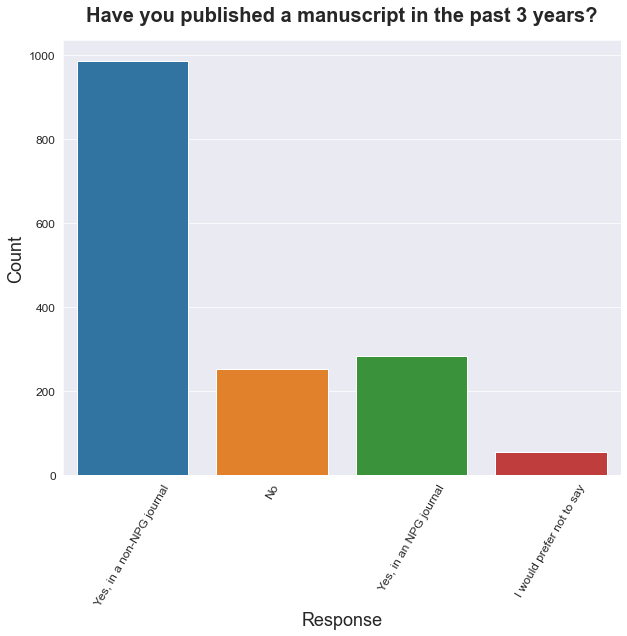

In [51]:
fig, ax = plt.subplots(figsize = (10,8))
column_title="Yes, in an NPG journal"
ax=sns.countplot(x=column_title, data=data3)
ax.set_title('Have you published a manuscript in the past 3 years?',fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.03)
ax.set_xlabel('Response',fontsize = 18 )
ax.set_ylabel('Count',fontsize = 18 )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
ax.tick_params(labelsize=12)

plt.show()


### Q2: 'Is a "crisis of reproducibility" something you have heard of before, as an issue in science?'

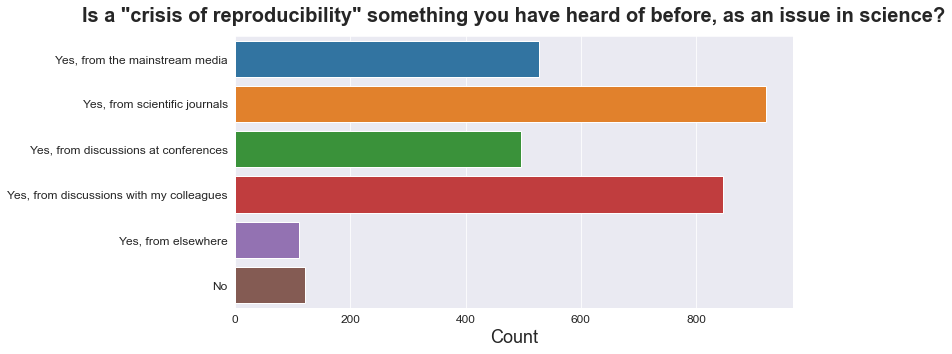

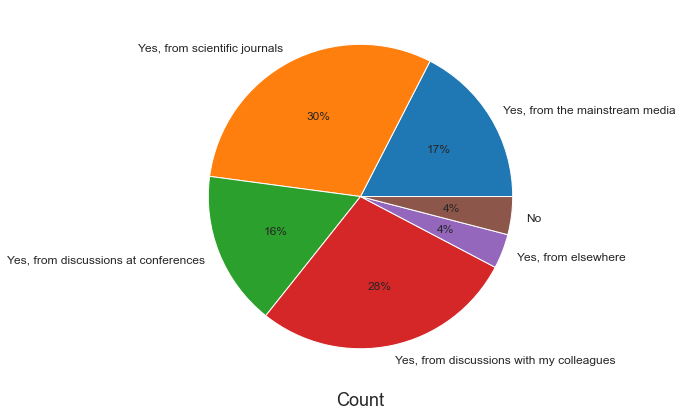

In [52]:
x={i:sum(data3[i]!='NaN') for i in data3.columns[1:7]}
keys = list(x.keys())
vals =list(x.values()) 
column_title='Is a "crisis of reproducibility" something you have heard of before, as an issue in science?'

fig, ax = plt.subplots(figsize = (10,5))
ax=sns.barplot(x=vals, y=keys)
ax.set_title(column_title,fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.03)
#ax.set_ylabel('Response',fontsize = 18 )
ax.set_xlabel('Count',fontsize = 18 )
ax.set_yticklabels(ax.get_yticklabels())
ax.tick_params(labelsize=12)
plt.show()


fig, ax1 = plt.subplots(figsize = (7,7))
ax1.pie(vals, labels = keys, autopct='%.0f%%', textprops={'fontsize': 12})
ax1.set_xlabel('Count',fontsize = 18 )
ax1.tick_params(labelsize=12)
plt.show()

### Q3: 'To what extent do you agree or disagree with the following statements?'

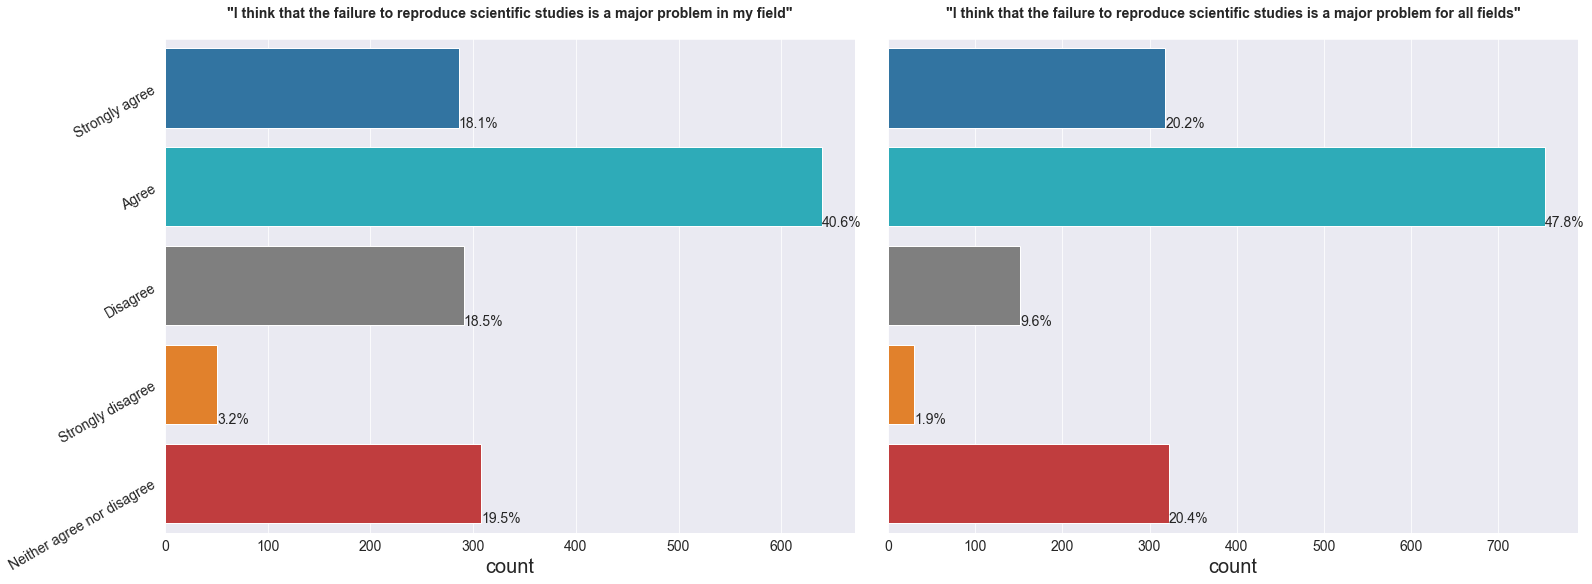

In [53]:
fig, ax = plt.subplots(1,2,figsize = (22,8),constrained_layout=True)
category_order = ["Strongly agree","Agree","Disagree","Strongly disagree","Neither agree nor disagree"]
col1='"I think that the failure to reproduce scientific studies is a major problem in my field"'
col2='"I think that the failure to reproduce scientific studies is a major problem for all fields"'
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']
g1=sns.countplot(y=col1, ax=ax[0],order=category_order,data=data3, palette=colors)
g2=sns.countplot(y=col2, ax=ax[1],order=category_order,data=data3,  palette=colors)
#fig.tight_layout()
g1.set(ylabel=None)
g2.set(ylabel=None)


g1.set_title(col1,fontsize = 14,fontweight='bold',y =1.03)
g2.set_title(col2,fontsize = 14,fontweight='bold',y =1.03)
g1.xaxis.get_label().set_fontsize(20)
g2.xaxis.get_label().set_fontsize(20)

labels = [item.get_text() for item in g1.get_yticklabels()]
#print(labels)
g1.set_yticklabels(labels=labels, rotation = 30)
g2.set(yticks=[])


g1.tick_params(labelsize=14)
g2.tick_params(labelsize=14)


def percentage_show(plot, feature):
    total = len(feature)
    #print(total)
    for pt in plot:
        for p in pt.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            y = p.get_y() + p.get_height()
            pt.annotate(percentage, (p.get_width(),y), size = 14)
            #print(percentage, p.get_width(),y)

percentage_show([g1,g2], data3)


### Q4: How often do you do any of the following? 

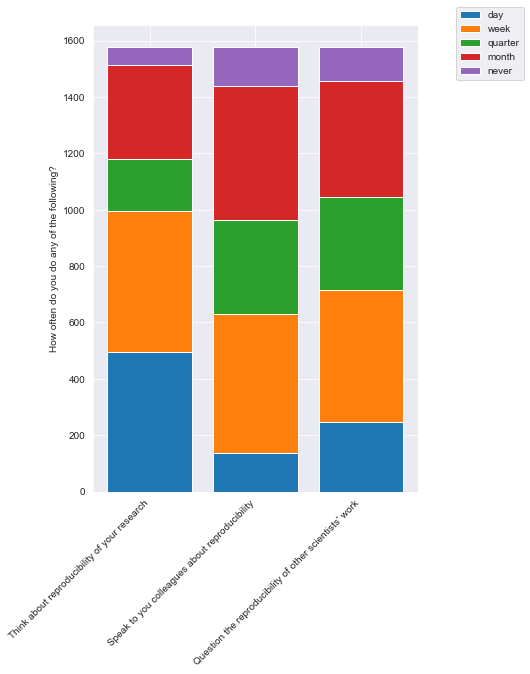

In [54]:
datalist=[]
for i in range(9,12):
    d=data3.groupby(data3.columns[i]).size().to_frame()
    d=d.rename(columns={0: d.index.name})
    d.index.name = None
    datalist.append(d.T)
    
myDataFrame = pd.DataFrame() 

for new_data in datalist:
    myDataFrame=pd.concat([myDataFrame, new_data])
    

fig, ax = plt.subplots(figsize=(7,7))
ax.bar(myDataFrame.index, myDataFrame['Daily'], label="day")
ax.bar(myDataFrame.index, myDataFrame['Weekly'], bottom= myDataFrame['Daily'],
label="week")
ax.bar(myDataFrame.index, myDataFrame['Quarterly'], bottom= myDataFrame['Daily']+myDataFrame['Weekly'], label="quarter")
ax.bar(myDataFrame.index, myDataFrame['Monthly'], bottom= myDataFrame['Daily']+myDataFrame['Weekly']+myDataFrame['Quarterly'], label="month")
ax.bar(myDataFrame.index, myDataFrame['Never'], bottom= myDataFrame['Daily']+myDataFrame['Weekly']+myDataFrame['Quarterly']+ myDataFrame['Monthly'], label="never")
fig.tight_layout()

plt.setp(ax.xaxis.get_majorticklabels(),rotation=45, ha='right')

ax.set_ylabel('How often do you do any of the following?')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()


### Q5: To what extent do you agree or disagree with the following statements:

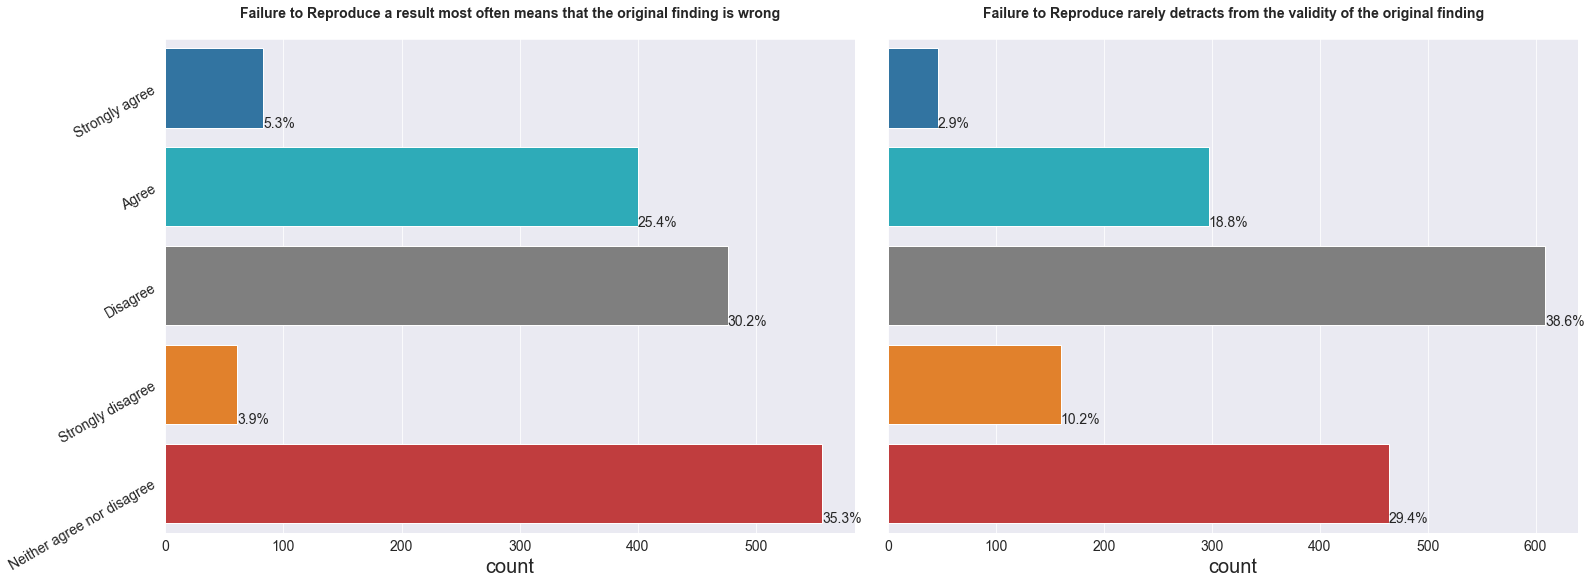

In [55]:
fig, ax = plt.subplots(1,2,figsize = (22,8),constrained_layout=True)
category_order = ["Strongly agree","Agree","Disagree","Strongly disagree","Neither agree nor disagree"]
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

g1=sns.countplot(y=data3.columns[12], ax=ax[0],order=category_order,data=data3, palette=colors)
g2=sns.countplot(y=data3.columns[13], ax=ax[1],order=category_order,data=data3,  palette=colors)
#fig.tight_layout()
g1.set(ylabel=None)
g2.set(ylabel=None)
#print(data3.columns[12],data3.columns[13])

g1.set_title('Failure to Reproduce a result most often means that the original finding is wrong',fontsize = 14,fontweight='bold',y =1.03)
g2.set_title('Failure to Reproduce rarely detracts from the validity of the original finding',fontsize = 14,fontweight='bold',y =1.03)
g1.xaxis.get_label().set_fontsize(20)
g2.xaxis.get_label().set_fontsize(20)

labels = [item.get_text() for item in g1.get_yticklabels()]
#print(labels)
g1.set_yticklabels(labels=labels, rotation = 30)
g2.set(yticks=[])


g1.tick_params(labelsize=14)
g2.tick_params(labelsize=14)


def percentage_show(plot, feature):
    total = len(feature)
    #print(total)
    for pt in plot:
        for p in pt.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            y = p.get_y() + p.get_height()
            pt.annotate(percentage, (p.get_width(),y), size = 14)
            #print(percentage, p.get_width(),y)

percentage_show([g1,g2], data3)


### Q6: 'Please use the scale below to indicate how much each of the following factors contributes to a failure to reproduce results'

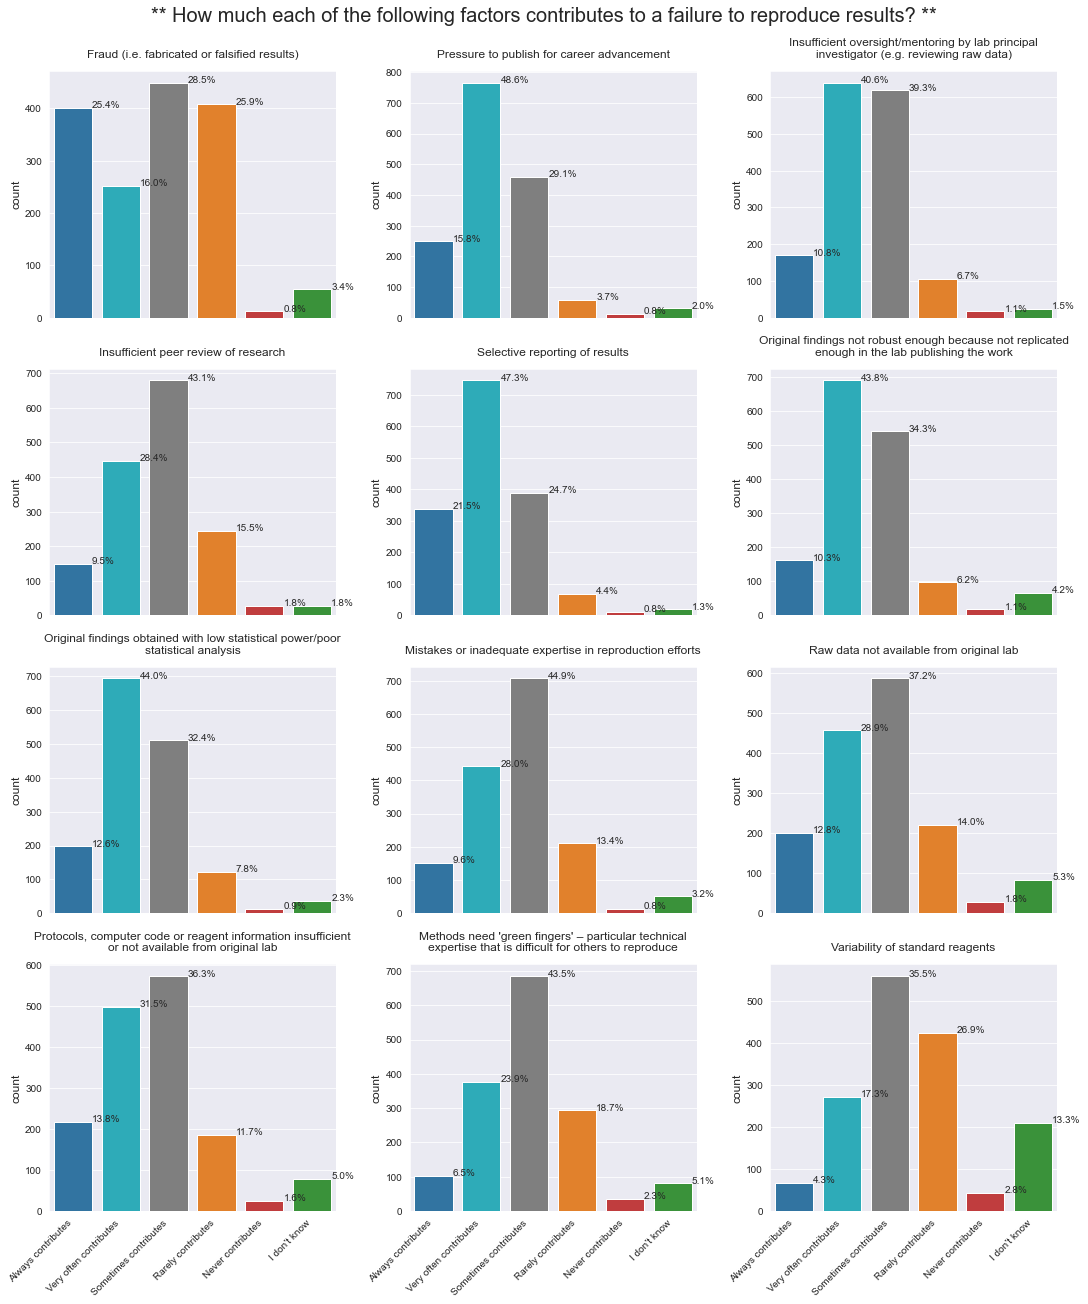

In [56]:
from textwrap import wrap

k=-1
fig, ax = plt.subplots(4,3,figsize = (15,18), constrained_layout=True)
#fig, ax = plt.subplots(4,3,figsize = (15,17),constrained_layout=True)
fig.suptitle('** How much each of the following factors contributes to a failure to reproduce results? **', fontsize=20)
#plt.style.use('seaborn')
category_order = ["Always contributes","Very often contributes","Sometimes contributes","Rarely contributes","Never contributes",'I don\'t know']

colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red', 'tab:green']
for i in range(14,26):
        j=(i-2)%3
        if(j==0):
            k=k+1
        g=sns.countplot(x=data3.columns[i], ax=ax[k][j],order=category_order,data=data3, palette=colors) 
        g.set(xlabel=None)
   
        g.set_title("\n".join(wrap(data3.columns[i], 60)),fontsize = 12,y =1.03)
        g.yaxis.get_label().set_fontsize(12)


        labels = [item.get_text() for item in g.get_xticklabels()]
        if(k==3):
            plt.setp(g.xaxis.get_majorticklabels(),rotation=45, ha='right')
        else:
            g.set(xticks=[])

        #g1.tick_params(labelsize=10)
        #g2.tick_params(labelsize=10)


        def percentage_show(plot, feature):
            total = len(feature)
            #print(total)
            for p in plot.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height()/total)
                x = p.get_x() + p.get_width()
                plot.annotate(percentage, (x,p.get_height()))
               # print(percentage, p.get_width(),y)
        
        percentage_show(g, data3)



### Q7: 'Please use the scale below to indicate how likely you think the following factors would be to improve the reproducibility of research.'

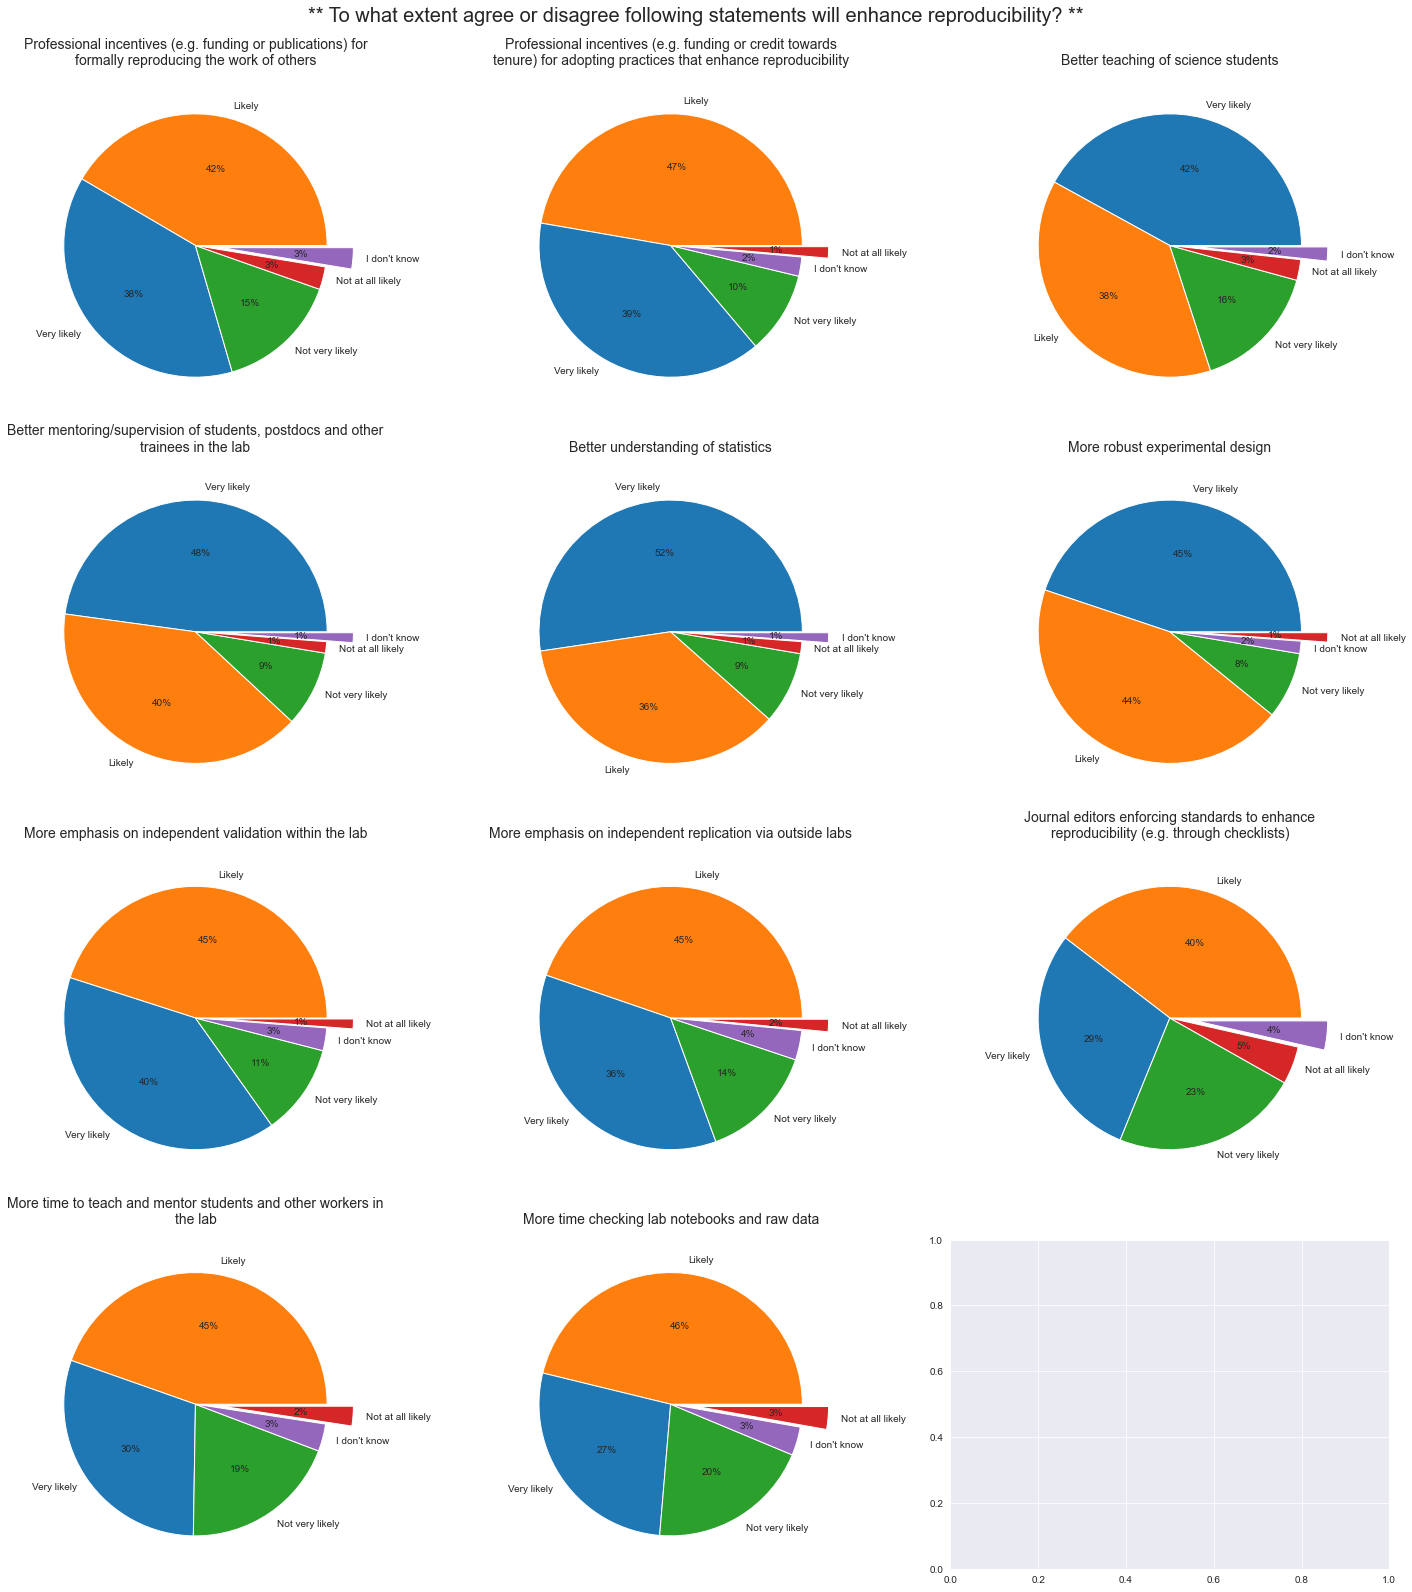

In [57]:
#column=data3.iloc[:, 28:39].columns
fig, ax = plt.subplots(4,3,figsize = (20,22),constrained_layout=True)
fig.suptitle('** To what extent agree or disagree following statements will enhance reproducibility? **', fontsize=20)
colours = {'Very likely':'C0', 'Likely':'C1', 'Not very likely':'C2', 'Not at all likely':'C3', 'I don\'t know':'C4'}
k=-1
for i in range(28,39):
    j=(i-1)%3
    if(j==0):
        k=k+1
    temp_series = data3[data3.columns[i]].value_counts()
    x = list((np.array((temp_series / temp_series.sum())*100)))
    labels = list(np.array(temp_series.index))
    #print(labels)
    explode = [0, 0, 0, 0, 0.2]
    ax[k][j].pie(x, labels = labels, colors = [colours[key] for key in labels], autopct='%.0f%%', explode = explode)
    ax[k][j].set_title("\n".join(wrap(data3.columns[i], 60)),fontsize = 14,y =1.03)
    
plt.show()


### Q8: Which, if any, of the following have you done?

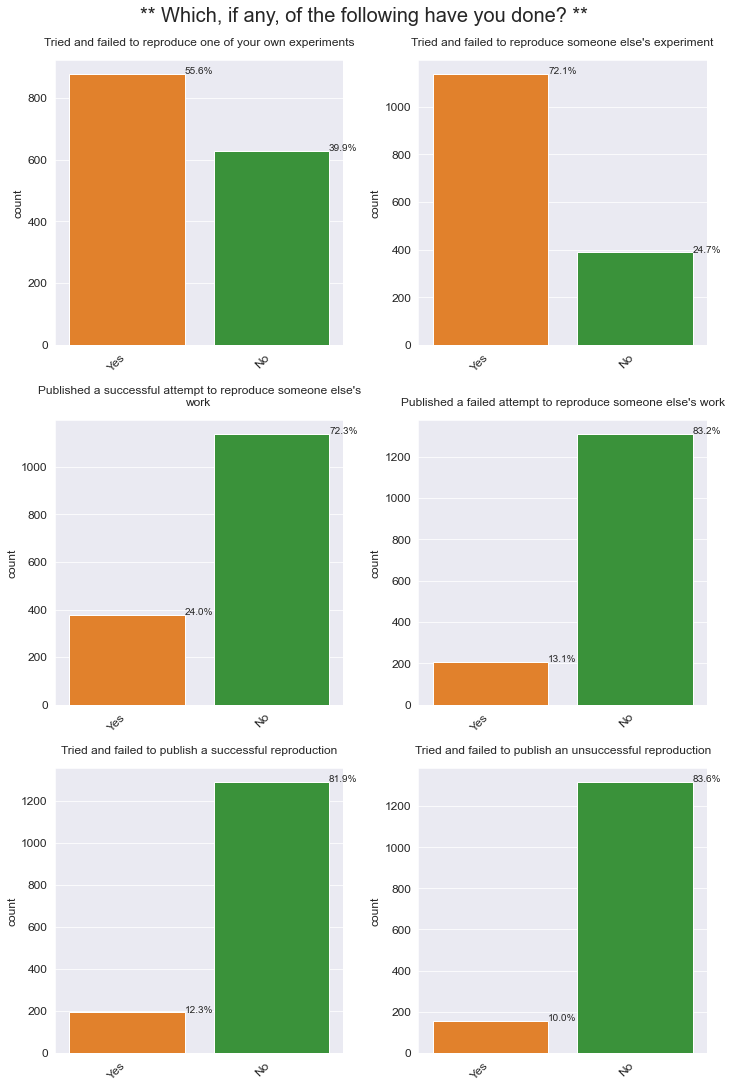

In [58]:
#list1=data3.iloc[:,39:48].unique()

k=-1
fig, ax = plt.subplots(3,2,figsize = (10,15), constrained_layout=True)
fig.suptitle('** Which, if any, of the following have you done? **', fontsize=20)
#plt.style.use('seaborn')
category_order = ['Yes','No']

colors = ['tab:orange','tab:green']
for i in range(39,45):
        j=(i+1)%2
        if(j==0):
            k=k+1
        g=sns.countplot(x=data3.columns[i], ax=ax[k][j],order=category_order,data=data3, palette=colors) 
        g.set(xlabel=None)
   
        g.set_title("\n".join(wrap(data3.columns[i], 60)),fontsize = 12,y =1.03)
        g.yaxis.get_label().set_fontsize(12)


        labels = [item.get_text() for item in g.get_xticklabels()]
        plt.setp(g.xaxis.get_majorticklabels(),rotation=45, ha='right')


        g.tick_params(labelsize=12)
        #g2.tick_params(labelsize=10)


        def percentage_show(plot, feature):
            total = len(feature)
            #print(total)
            for p in plot.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height()/total)
                x = p.get_x() + p.get_width()
                plot.annotate(percentage, (x,p.get_height()))
               # print(percentage, p.get_width(),y)
        
        percentage_show(g, data3)



**References:** <br>

Data Source: https://figshare.com/articles/dataset/Nature_Reproducibility_survey/3394951 <br>

[1]	John P. A. Ioannidis (2005) Why Most Published Research Findings Are False, CHANCE, 18:4, 40-47, DOI: 10.1080/09332480.2005.10722754 <br>
[2]	https://www.sciencedirect.com/science/article/pii/S2352340918303597?via%3Dihub <br>
[3]	http://nrs.harvard.edu/urn-3:HUL.InstRepos:8355188<br>
[4]	doi:10.2188/jea.JE20110087<br>
[5]	The Annals of Applied Statistics 2011, Vol. 5, No. 3, 1752–1779 DOI: 10.1214/11-AOAS466 © Institute of Mathematical Statistics, 2011<br>
[6]	Hardwicke TE et al. 2018 Data availability, reusability, and analytic reproducibility: evaluating the impact of a mandatory open data policy at the journal Cognition. R. Soc. open sci. 5: 180448. http://dx.doi.org/10.1098/rsos.180448 <br>
[7]	Mobley A, Linder SK, Braeuer R, Ellis LM, Zwelling L (2013) A Survey on Data Reproducibility in Cancer Research Provides Insights into Our Limited Ability to Translate Findings from the Laboratory to the Clinic. PLoS ONE 8(5): e63221. doi:10.1371/journal.pone.0063221 <br>
[8]	J. Burke, “The Impact of Science on Society,” 1985. [Online].  <br>
[9]	P. E. Stephan, How economics shapes science, vol. 1. Harvard University Press Cambridge, MA, 2012. <br>
[10]	V. Bush, “Science: The endless frontier,” Trans. Kans. Acad. Sci., vol. 48, no. 3, pp. 231–264, 1945. <br>
[11]	M. Baker, “1,500 scientists lift the lid on reproducibility,” Nature, vol. 533, no. 7604, pp. 452–454, May 2016. <br>
[12]	D. Sarewitz, “The pressure to publish pushes down quality,” Nature, vol. 533, no. 7602, p. 147, May 2016. <br>
[13]	L. P. Freedman, I. M. Cockburn, and T. S. Simcoe, “The Economics of Reproducibility in Preclinical Research,” PLoS Biol., vol. 13, no. 6, p. e1002165, Jun. 2015.<br>
 [14]	H. Pashler and E.-J. Wagenmakers, “Editors’ Introduction to the Special Section on Replicability in Psychological Science: A Crisis of Confidence?,” Perspect. Psychol. Sci., vol. 7, no. 6, pp. 528–530, Nov. 2012.<br>
[15]	J. P. A. Ioannidis, “Why Science Is Not Necessarily Self-Correcting,” Perspect. Psychol. Sci., vol. 7, no. 6, pp. 645–654, 2012.<br>
[16]	J. P. A. Ioannidis, “The Proposal to Lower P Value Thresholds to .005,” JAMA, Mar. 2018, doi: 10.1001/jama.2018.1536.<br>
[17]	J. P. A. Ioannidis, “Meta-research: Why research on research matters,” PLoS Biol., vol. 16, no. 3, p. e2005468, Mar. 2018.<br>
[18]	J. P. A. Ioannidis, “Why Most Published Research Findings Are False,” Chance , vol. 18, no. 4, pp. 40–47, 2005.<br>
 [19]	S. M. Nutley, I. Walter, and H. T. O. Davies, Using Evidence: How Research Can Inform Public Services. Policy Press, 2007.<br>
 [20]	S. Bowen and A. B. Zwi, “Pathways to ‘Evidence-Informed’ Policy and Practice: A Framework for Action,” PLoS Med., vol. 2, no. 7, p. e166, May 2005.<br>
 [21]	J. Van Bavel, “Why do so many studies fail to replicate,” NY Times , vol. 165, 2016.<br>
 [22]	D. B. Resnik, “Scientific research and the public trust,” Sci. Eng. Ethics, vol. 17, no. 3, pp. 399–409, Sep. 2011.<br>
 [23]	J. P. A. Ioannidis, “Why replication has more scientific value than original discovery,” The Behavioral and brain sciences, vol. 41. p. e137, Jan-2018.<br>
[24]	J. Kovacevic, “How to Encourage and Publish Reproducible Research,” in 2007 IEEE International Conference on Acoustics, Speech and Signal Processing - ICASSP ’07, 2007, doi: 10.1109/icassp.2007.367309.<br>
 [25]	M. Callaham, R. L. Wears, and E. Weber, “Journal prestige, publication bias, and other characteristics associated with citation of published studies in peer-reviewed journals,” JAMA, vol. 287, no. 21, pp. 2847–2850, Jun. 2002.<br>
[26]	Penny, Dan (2016): Nature Reproducibility survey figshare. Dataset available: https://doi.org/10.6084/m9.figshare.3394951.v1 <br>

